In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import glob
from urllib.request import urlopen, Request 
from path import Path, getcwdu
import os
from pathlib import PurePath

In [36]:
train_file_list = [PurePath(file).name for file in glob.iglob('data/nc_training_filings/*')]
train_path_list = [PurePath(os.getcwd()).joinpath(file).as_posix() for file in glob.iglob('data/nc_training_filings/*')]
train_accession_ids = [PurePath(file).stem for file in train_file_list]
train_cik_nbrs = [x.split(sep='-')[0] for x in train_accession_ids]

In [99]:
srp_df = pd.read_csv('data/share_repurchase_paragraphs.csv').sort_values('accession_number').reset_index()

In [133]:
srp_df['para_len'] = srp_df['paragraph_text'].apply(lambda x: len(x))

In [152]:
srp_df.columns

Index(['index', 'ticker', 'accession_number', 'data_key_friendly_name', 'text',
       'data_value', 'reported_data_value', 'reported_units', 'paragraph_text',
       'para_len'],
      dtype='object')

In [138]:
import matplotlib.pyplot as plt

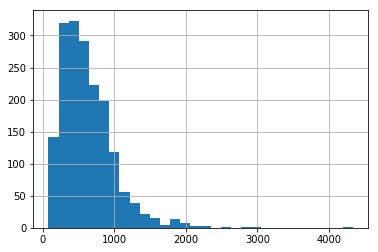

In [141]:
srp_df.para_len.hist(bins=30)
plt.show()

In [336]:
def print_para_info(df=srp_df, nrow=10, sortby=['accession_number', 'data_key_friendly_name'], ascending=True):
    df_sorted = df.sort_values(sortby, ascending=ascending).reset_index()
    nrow = min(len(df_sorted), nrow)
    for i in range(0, nrow):
        print('------------------------------------   ' +  df_sorted['ticker'][i] + '   --------------------------------')
        print('------------------------------------   ' +  df_sorted['accession_number'][i] + '   --------------------------------')
        print (df_sorted['data_key_friendly_name'][i])
        print('')
        print(df_sorted['text'][i])
        print('')
        print(df_sorted['paragraph_text'][i])
        print('')

In [337]:
print_para_info(df=srp_df[srp_df.accession_number == '0001564590-18-002832'], sortby=['para_len'], ascending=False)

------------------------------------   TXN   --------------------------------
------------------------------------   0001564590-18-002832   --------------------------------
Amount Spent on Share Repurchases

Stock repurchases

For Years Ended December 31,   (Millions of   dollars, except   share and per-share   amounts)                   2017              2016              2015              2014              2013   Cash flow data:   Cash flows from   operating activities   $      5,363      $      4,614      $      4,397      $      4,054      $      3,514   Capital expenditures            695               531               551               385               412   Free cash flow (a)            4,668             4,083             3,846             3,669             3,102   Dividends paid                2,104             1,646             1,444             1,323             1,175   Stock repurchases             2,556             2,132             2,741             2,831             2,8

In [146]:
srp_df.sort_values(['para_len'], ascending=False).head()

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
309,1273,PEP,0000077476-18-000012,Share Repurchase Count,Share repurchases,18000000,18.0,millions,2017 2016 20...,4332
311,1279,PEP,0000077476-18-000012,Amount Spent on Share Repurchases,Share repurchases,2000000000,2000.0,millions,2017 2016 20...,4332
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.0,millions,"For Years Ended December 31, (Millions of ...",3017
392,1645,UTX,0000101829-18-000005,Amount Spent on Share Repurchases,Repurchases of Common Stock ^3,1453000000,1453.0,millions,"(dollars in millions, except per share amounts...",2899
1478,1126,MMM,0001558370-18-000535,Share Repurchase Intention,"Total January 1-December 31, 2017",5070000000,5070.0,millions,Maximum ...,2536


In [155]:
srp_df[srp_df.accession_number == '0001564590-18-002832']

,index,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,para_len
1576,1599,TXN,0001564590-18-002832,Share Repurchase Intention,stock repurchase authorizations remain,9240000000,9.24,billions,Treasury shares were acquired in connection wi...,223
1577,1595,TXN,0001564590-18-002832,Share Repurchase Authorization,board of directors authorized the purchase of ...,6000000000,6.00,billions,All open-market purchases during the quarter w...,348
1578,1596,TXN,0001564590-18-002832,Share Repurchase Authorization Date,"September 21, 2017",20170921,20200000.00,ones,All open-market purchases during the quarter w...,348
1579,1597,TXN,0001564590-18-002832,Share Repurchase Count,repurchase,30600000,30.60,millions,"In 2017, financing activities used $3.73 billi...",764
1580,1594,TXN,0001564590-18-002832,Share Repurchase Authorization,authorization,7500000000,7.50,billions,All open-market purchases during the quarter w...,348
1581,1598,TXN,0001564590-18-002832,Amount Spent on Share Repurchases,Stock repurchases,2556000000,2556.00,millions,"For Years Ended December 31, (Millions of ...",3017


In [ ]:
#https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany&CIK=0000002969&type=10-K&dateb=20171031&owner=include&count=40

In [185]:
import re

In [312]:

def df_from_html_tbl(table_tag):
    data_re = re.compile(r'[a-zA-Z0-9$().]+')
    repl = re.compile(r'[()$]')
    rows = []
    for row in table_tag.findChildren('tr'):
        row_list = []
        for s in row.strings:
            s = re.sub(repl, '', s.strip())
            if len(s) > 0:
                row_list.append(s)
        if len(row_list) > 1:
            rows.append(row_list)
    tbl_df = pd.DataFrame.from_records(rows)
    try:
        tbl_df = tbl_df.set_index( tbl_df.applymap(len).max().values.argmax()) 
    except: tbl_df = tbl_df.set_index(0)
    return tbl_df

In [329]:
repurch_pat = re.compile(r'repurchase|ASR', flags=re.I)
repurch_TXN = soup_TXN.find_all(string=[repurch_pat])
def print_repurch_hits(filepath):
    try:
        with open(filepath) as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    except: 
        with open(filepath, encoding="utf8") as file: 
            file_html = file.read()
            soup = BeautifulSoup(file_html, 'lxml')
    soup_repurch = soup.find_all(string=[repurch_pat])
    doc_dict = {}
    for idx, item in enumerate(repurch_TXN):
        if item.find_parent('table') is None:
            doc_dict[idx] = item.parent
        else:
            doc_dict[idx] = df_from_html_tbl(item.find_parent('table'))
    return doc_dict


In [330]:
test_dict = print_repurch_hits(train_path_list[0])

In [328]:
with open('C:/projects/DSBC/data-question-8-waving-tigers/data/nc_training_filings/0001564590-18-002832.html', encoding="utf8") as file: 
    html_TXN = file.read()
    soup_TXN = BeautifulSoup(html_TXN, 'lxml')
pretty_soup_TXN = soup_TXN.prettify()
soup_text_TXN = soup_TXN.get_text()


In [165]:
html_TXN.find('ITEM 6', html_TXN.find('ITEM 6') )

308281

In [167]:
pretty_soup_TXN.find('ITEM 6', pretty_soup_TXN.find('ITEM 6') )

328661

In [170]:
soup_text_TXN.find('ITEM 6')

259770

In [172]:
print(soup_text_TXN[259770:265770])

ITEM 6.


Selected Financial
Data.















For Years Ended December 31,







(Millions of dollars, except share and per-share amounts)





2017








2016








2015








2014








2013







Cash flow data:















































































Cash flows from operating activities





$





5,363








$





4,614








$





4,397








$





4,054








$





3,514







Capital expenditures











695














531














551














385














412







Free cash flow (a)











4,668














4,083














3,846














3,669














3,102







Dividends paid











2,104














1,646














1,444














1,323














1,175







Stock repurchases











2,556














2,132














2,741














2,831














2,868












































































In [175]:
print(pretty_soup_TXN[328400:332661])

  </p>
     </td>
    </tr>
   </table>
  </div>
  <p class="c61">
   15
  </p>
  <hr class="c51"/>
  <div class="c10">
   <table border="0" cellpadding="0" cellspacing="0" class="c9">
    <tr>
     <td class="c55" valign="bottom">
      <p class="c54">
       ITEM 6.
      </p>
     </td>
     <td valign="bottom">
      <p class="c221">
       <a id="Section49EF47CEAB0F1E8B911B52F749D9A40B" name="Section49EF47CEAB0F1E8B911B52F749D9A40B">
       </a>
       <span class="c52">
        <a id="Section49EF47CEAB0F1E8B911B52F749D9A40B" name="Section49EF47CEAB0F1E8B911B52F749D9A40B">
        </a>
        Selected Financial
Data.
       </span>
      </p>
     </td>
    </tr>
   </table>
  </div>
  <p class="c57">
  </p>
  <div>
   <table align="center" border="0" cellpadding="0" cellspacing="0" class="c9">
    <tr>
     <td class="c223" valign="bottom">
      <p class="c222">
      </p>
     </td>
     <td class="c225" valign="bottom">
      <p class="c224">
      </p>
     </td>
     <td cl

In [166]:
print(html_TXN[308281:312281])

ITEM 6.</p>
</td>
<td valign="bottom" >
<p class="c221"><a name="Section49EF47CEAB0F1E8B911B52F749D9A40B" id=
"Section49EF47CEAB0F1E8B911B52F749D9A40B"></a><span class="c52"><a name=
"Section49EF47CEAB0F1E8B911B52F749D9A40B" id="Section49EF47CEAB0F1E8B911B52F749D9A40B"></a>Selected Financial
Data.</span></p>
</td>
</tr>
</table>
</div>
<p class="c57"></p>
<div>
<table border="0" cellspacing="0" cellpadding="0" align="center" class="c9">
<tr>
<td valign="bottom"  class="c223">
<p class="c222"></p>
</td>
<td valign="bottom"  class="c225">
<p class="c224"></p>
</td>
<td valign="bottom"  colspan="23" class="c227">
<p class="c226">For Years Ended December 31,</p>
</td>
<td valign="bottom"  class="c228">
<p class="c222"></p>
</td>
</tr>
<tr>
<td valign="bottom"  class="c223">
<p class="c222">(Millions of dollars, except share and per-share amounts)</p>
</td>
<td valign="bottom"  class="c225">
<p class="c224"></p>
</td>
<td valign="bottom"  colspan="3" class="c229">
<p class="c226">2017</p>
<

In [42]:
with open(train_path_list[0]) as file: 
    html_APD = file.read()
    soup_APD = BeautifulSoup(html_APD)
soup_text_APD = soup_APD.get_text()
pretty_soup_APD = soup_APD.prettify()
pretty_soup_APD.find('ITEM 5', 100000 )

C:\Anaconda\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Anaconda\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [127]:
print(pretty_soup[174349:196349])

ITEM 5.    MARKET FOR REGISTRANT'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,
  </div>
  <div class="c99">
   AND ISSUER PURCHASES OF EQUITY SECURITIES
  </div>
  <div class="c77">
   <span class="c76">
    Our common stock (ticker symbol APD) is listed on the New York Stock
Exchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,
Brentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,
http://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31
October
   </span>
   <span class="c76">
    2017
   </span>
   <span class="c76">
    , there were 5,644 record holders of our common
stock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and
dividend information for the last two fiscal years appear below. Cash dividends on the Company's common stock
are paid quarterly. It is our expectation that we

In [75]:
html.find('ITEM 5', html.find('ITEM 5')+1 )

159919

In [124]:
#print(html[159919:175919])
html[159919:225919]

'ITEM 5.    MARKET FOR REGISTRANT\'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,</div>\n<div class="c99">AND ISSUER PURCHASES OF EQUITY SECURITIES</div>\n<div class="c77"><span class="c76">Our common stock (ticker symbol APD) is listed on the New York Stock\nExchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,\nBrentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,\nhttp://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31\nOctober</span> <span class="c76">2017</span><span class="c76">, there were 5,644 record holders of our common\nstock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and\ndividend information for the last two fiscal years appear below. Cash dividends on the Company\'s common stock\nare paid quarterly. It is our expectation that we will continue to pay cash dividends

In [81]:
soup_text.find('ITEM 5', html.find('ITEM 5')+1 )

123361

In [119]:
#print(soup_text[123361:124361])
soup_text[123361:145361]

'ITEM 5.    MARKET FOR REGISTRANT\'S COMMON EQUITY, RELATED STOCKHOLDER MATTERS,\nAND ISSUER PURCHASES OF EQUITY SECURITIES\nOur common stock (ticker symbol APD) is listed on the New York Stock\nExchange. Our transfer agent and registrar is Broadridge Corporate Issuer Solutions, Inc., P.O. Box 1342,\nBrentwood, New York 11717, telephone (844) 318-0129 (U.S.) or (720) 358-3595 (all other locations); website,\nhttp://shareholder.broadridge.com/airproducts; and e-mail address, shareholder@broadridge.com. As of 31\nOctober 2017, there were 5,644 record holders of our common\nstock. Quarterly stock prices, as reported on the New York Stock Exchange composite tape of transactions, and\ndividend information for the last two fiscal years appear below. Cash dividends on the Company\'s common stock\nare paid quarterly. It is our expectation that we will continue to pay cash dividends in the future at\ncomparable or increased levels. The Board of Directors determines whether to declare dividends 

In [39]:
len(srp_df.accession_number.unique())

435

In [37]:
srp_df.data_key_friendly_name.value_counts().to_frame('counts')

,counts
Share Repurchase Authorization Date,401
Share Repurchase Authorization,369
Amount Spent on Share Repurchases,329
Share Repurchase Count,286
Share Repurchase Intention,227
Unknown Share Repurchase Data,122
Share Repurchase Utilization,47


In [49]:
srp_df.text.value_counts()

repurchased                                                                                                                     233
Total                                                                                                                            40
purchased                                                                                                                        29
repurchase                                                                                                                       23
2017                                                                                                                             22
December 2017                                                                                                                    19
at a cost of                                                                                                                     17
May 2017                                                                    

In [36]:

#srp_df[['data_key_friendly_name', 'text']].agg('count', axis=1)
srp_df[['data_key_friendly_name', 'text']].groupby(['data_key_friendly_name']).text.value_counts().to_frame('counts')

counts
data_key_friendly_name            text                                                      
Amount Spent on Share Repurchases repurchased                                             94
                                  at a cost of                                            16
                                  purchased                                               11
                                  repurchase                                              10
                                  2017                                                     9
                                  Total                                                    9
                                  aggregate cost                                           7
                                  at a total cost of                                       6
                                  at an aggregate cost of                                  6
                                  for a total of                                           6
                                  Total cost                                               5
                                  Repurchase of common stock                               4
                                  Share repurchases                                        3
                                  Total share repurchases                                  3
                                  aggregate cost of                                        3
                                  share repurchases                                        3
                                  total cost                                               3
                                  Aggregate purchase price                                 2
                                  Cost of shares repurchased                               2
                                  Total cost of repurchases                                2
                                  Total repurchases                                        2
                                  aggregate amount                                         2
                                  cost                                                     2
                                  for a total cost of                                      2
                                  total amount of                                          2
                                  2017 Program                                             1
                                  2017 Repurchases                                         1
                                  Aggregate cost                                           1
                                  Aggregate cost, including fees                           1
                                  Aggregate purchase price of common stock repurc...       1
...                                                                                      ...
Unknown Share Repurchase Data     the Board of Directors approved a plan which au...       1
                                  the Board of Directors approved a share repurch...       1
                                  the Board of Directors authorized a share repur...       1
                                  the Board of Directors authorized the purchase ...       1
                                  the Board of Directors of the Company approved ...       1
                                  the Board renewed the Company's share repurchas...       1
                                  the Company had authorization to maintain up to          1
                                  the Company had repurchased a total of approxim...       1
                                  the Company's Board of Directors approved a rep...       1
                                  the Company's Board of Directors authorized an ...       1
                                  the Company's Board of Directors authorized an ...   

In [17]:
srp_df.data_key_friendly_name.value_counts()

Share Repurchase Authorization Date    401
Share Repurchase Authorization         369
Amount Spent on Share Repurchases      329
Share Repurchase Count                 286
Share Repurchase Intention             227
Unknown Share Repurchase Data          122
Share Repurchase Utilization            47
Name: data_key_friendly_name, dtype: int64